# Rule-based Relation Extraction

In [1]:
import spacy
import scispacy
import en_ner_bc5cdr_md as ner
from spacy import displacy
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt

### Loading NLP Model
We use the pre-trained NER model `en_ner_bc5cdr_md` as our language model. Since we will be dealing with small chemicals/metabolites, this has the benefit of identifying the relevant biochemical entities from the text. 

In [2]:
nlp = ner.load()

In this notebook, we will be exploring three (3) rule-based approaches to relation extraction, specifically for extracting metabolic reactions. Each approach is shown to be effective for a particular sentence structure and this is used to illustrate the application of each approach.

### Approach 1: Dependency Parsing

The first approach uses dependency parsing and takes advantage of dependency trees to extract relations. This is particularly effective for sentences where (1) the metabolic reaction is explicitly the main verb (root) of the sentence; and (2) the metabolites are subjects or objects of the sentence, as shown in the following example:

In [3]:
doc = nlp("Caffeine is metabolized extensively to paraxanthine.")
doc

Caffeine is metabolized extensively to paraxanthine.

Before extracting relations, we first must identify the entities involved. This is where the pre-trained NER model becomes handy. In the example sentence, the entities are identified as follows:

In [4]:
displacy.render(doc, jupyter=True, style="ent")

In order to help us later, we store these identified entities in a list called `entities`:

In [5]:
def get_entities(doc):
    entities = [str(ent).lower() for ent in doc.ents]
    entities = list(set(entities))
    return entities

In [6]:
entities = get_entities(doc)
entities

['caffeine', 'paraxanthine']

To understand dependency parsing, we visualize the dependency tree of the example sentence. Below we can see that the **root** of the sentence is the verb **metabolized** and the entities *caffeine* and *paraxanthine* are connected to it as its children. For sentence structures like this, we take advantage of this pattern.

In [7]:
displacy.render(doc, jupyter=True)

We define the following function `get_triples` to extract this relation. To be more verbose, this function takes all the **ROOTs** of the sentences in doc and gets the children that are identified as entities by the NER.

In [8]:
def get_triples(doc):
    triples = []
    for token in doc:
        if token.dep_ == "ROOT":
            triples.append((token.lemma_,[child.lemma_ for child in token.children if str(child).lower() in entities]))
    return triples

In [9]:
get_triples(doc)

[('metabolize', ['caffeine', 'paraxanthine'])]

To summarize, using Approach 1, we were able to extract the relation **metabolize(caffiene, paraxanthine)**. The weakness of Approach 1 is revealed when evaluating sentences where the metabolic reaction is not the root (main verb) of the sentence. For example:

In [10]:
doc1 = nlp("Studies have shown that caffeine metabolizes into paraxanthine.")

In [11]:
get_triples(doc1)

[('show', [])]

### Approach 2: Shortest Distance Path

This second approach works well with sentences of the same structure as the previous one (where the first approach failed). This approach borrows concepts from network analysis and extracts the relation between entities using the shortest distance path between them. To recall the example sentence is:

In [12]:
doc1

Studies have shown that caffeine metabolizes into paraxanthine.

In [13]:
displacy.render(doc1, jupyter=True)

Using the dependency tree, we form the edges of the network as the connection from token to its children.

In [14]:
def get_edges(doc):
    edges = []
    for token in doc:
        for child in token.children:
            edges.append(('{0}'.format(token.lower_),
                          '{0}'.format(child.lower_)))
    return edges

In [15]:
get_edges(doc1)

[('shown', 'studies'),
 ('shown', 'have'),
 ('shown', 'metabolizes'),
 ('shown', '.'),
 ('metabolizes', 'that'),
 ('metabolizes', 'caffeine'),
 ('metabolizes', 'paraxanthine'),
 ('paraxanthine', 'into')]

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


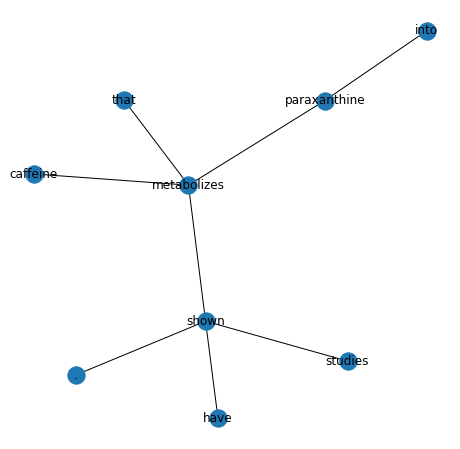

In [16]:
plt.figure(figsize=(8,8))
plt.axis("off")
G = nx.Graph()
G.add_edges_from(get_edges(doc1))
pos = nx.spring_layout(G, seed=2)
nx.draw_networkx(G, pos, font_color="black", with_labels=True)

In [17]:
entities = get_entities(doc1)
entities

['caffeine', 'paraxanthine']

In [18]:
entity1, entity2 = entities
print(nx.shortest_path(G, source=entity2, target=entity1))

['paraxanthine', 'metabolizes', 'caffeine']


As shown above, Approach 2 was able to extract the relation **metabolize(caffeine, paraxanthine)**.

### Approach 3: spaCy's Matcher pipeline

In both previous approaches, the metabolic reaction was expressed as an active verb (but not necessarily the main one (root) as the case in Approach 2). When the metabolic reaction is expressed in noun form, both previous approaches fail. This third approach, however, is able to extract relations in this sentence structure. Consider the following sentence:

In [19]:
doc2 = nlp("Experiments have shown that 7-N-demethylation of caffeine to theopylline accounts for 8% of the metabolism.")

We then use the spaCy's matcher pipeline to create a pattern that matcher would look for in the text. In this particular example, we are adding the pattern: 

`METABOLIC RXN NOUN` `OF` `ENITITY` `TO` `ENTITY`

In [20]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS":"NOUN"},{'LOWER': "of"},{'ENT_TYPE': 'CHEMICAL'},{"LOWER": "to"},{'ENT_TYPE': 'CHEMICAL'}]
matcher.add('CAND', None, pattern)

In [21]:
matches = matcher(doc2)
# Iterate over the matches
for match_id, start, end in matches:
    # Get the matched span
    matched_span = doc2[start:end]
    print(matched_span.text)

7-N-demethylation of caffeine to theopylline


In [22]:
def get_matches(doc):
    triples = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        matched_span = doc[start:end]
        triples += [doc[start], (doc[start+2], doc[end-1])]
    return triples

In [23]:
get_matches(doc2)

[7-N-demethylation, (caffeine, theopylline)]